# Step Detection

## Loading data

In [1]:
from datahandler.data_loader import load_data_from_file, load_date_from_steptracking_file
from datahandler.constants import v4_walking, location_labels
import os
from utils import print_line_divider
from datetime import timedelta
import pandas as pd
import numpy as np
from random import random
from sklearn.preprocessing import MinMaxScaler

#### Load file names

In [2]:
# Loading file names
def get_all_files_from_folder(folder):
    file_names = []
    for datafile in os.listdir(folder):
        if datafile.startswith("."):
            continue

        path = os.path.join(folder, datafile)
        if os.path.isfile(path):
            file_names.append(datafile)
    return file_names


data_dict = {}
for filename in get_all_files_from_folder(v4_walking):
    code = filename[:3]
    data_dict[code] = os.path.join(v4_walking, filename)

step_dict = {}
for filename in get_all_files_from_folder(v4_walking + "/step"):
    code = filename[:3]
    if code in data_dict.keys():
        step_dict[code] = os.path.join(v4_walking, "step", filename)

print(step_dict.keys())

dict_keys(['op1', 'px3', 'tc5', 'ss1', 'ps5', 'ps1', 'tc1', 'op5', 'px2', 'ps4', 'tc4', 'ss4', 'op4', 'ss3', 'op3', 'px1', 'px5', 'tc3', 'ps3', 'ss2', 'op2', 'px4', 'ps2', 'tc2'])


In [3]:
# Configuration
WINDOW_SIZE = 40
WINDOW_LENGTH_IN_SECONDS = 2

#### Load data from one file pair

In [4]:
# # Step 1 - Load data file
# code = "op1"
# df = load_data_from_file(data_dict[code])
# df = df.drop("labelActivity", axis=1)
# df['labelPhone'] = df['labelPhone'].apply(lambda x: location_labels.index(x))
# df

In [5]:
# # Step 2 - Load data file
# step_dates = load_date_from_steptracking_file(step_dict[code])
# print("There are " + str(len(step_dates)) + " steps found in this file")
# print(step_dates[int(len(step_dates) / 2)])

In [6]:
# # Step 3 - Divide collected data into fixed-size chunk
# fixed_size_data = []
# fixed_size_indexes = []
# current_timestamp = df.index[0].to_pydatetime()
# last_timestamp_raw = df.index[df.shape[0] - 1].to_pydatetime()
# current_timestamp_raw_index = 0
# one_window_length_in_millis = WINDOW_LENGTH_IN_SECONDS * 1000 / WINDOW_SIZE
# while True:
#     current_timestamp = current_timestamp + timedelta(milliseconds=one_window_length_in_millis)
#     if current_timestamp > last_timestamp_raw:
#         break
#
#     while current_timestamp_raw_index < df.shape[0] - 1:
#         next_timestamp_raw = df.index[current_timestamp_raw_index + 1].to_pydatetime()
#         if next_timestamp_raw < current_timestamp:
#             current_timestamp_raw_index += 1
#         else:
#             break
#
#     fixed_size_data.append(df.iloc[current_timestamp_raw_index])
#     fixed_size_indexes.append(current_timestamp)
# fixed_size_df = pd.DataFrame(
#     data=fixed_size_data,
#     index=fixed_size_indexes,
#     columns=df.columns
# )
#
# fixed_size_df

In [7]:
# # Step 4 - Add step date to this fixed_size_df
# def update_date_microsecond(date, first_rem, second_rem):
#     current_microsecond = date.microsecond
#     new_microsecond_one = (int(current_microsecond / 100000) * 100 + first_rem) * 1000
#     new_microsecond_two = (int(current_microsecond / 100000) * 100 + second_rem) * 1000
#     diff_one = abs(current_microsecond - new_microsecond_one)
#     diff_two = abs(current_microsecond - new_microsecond_one)
#     if diff_one > diff_two:
#         new_microsecond = new_microsecond_two
#     else:
#         new_microsecond = new_microsecond_one
#     return date.replace(microsecond=new_microsecond)
#
#
# index_first_date = fixed_size_df.index[0]
# print(type(index_first_date))
# milli = index_first_date.microsecond / 1000
# first_remainder = int(milli % 100)
# second_remainder = int((milli + 50) % 100)
#
# updated_step_dates = set()
# for date in step_dates:
#     updated_step_dates.add(update_date_microsecond(date, first_remainder, second_remainder))
#
# is_step_series = []
# count = 0
# for m in fixed_size_df.index:
#     is_step = m.to_pydatetime() in updated_step_dates
#     if is_step:
#         count += 1
#     is_step_series.append(is_step)
#
# print("Found " + str(count) + " steps in this data frame.")
#
# fixed_size_df['isStep'] = is_step_series
# fixed_size_df

In [8]:
# # Step 5 - Normalize the data
#
# def normalize(df):
#     feature_count = df.shape[1] - 2
#     values = df.iloc[:, 0:feature_count]
#     phone_labels = df.loc[:, "labelPhone"].set_axis(range(df.shape[0]))
#     is_step = df.loc[:, "isStep"].set_axis(range(df.shape[0]))
#     normalizer = MinMaxScaler()
#     normalized_values = normalizer.fit_transform(values)
#     normalized_df = pd.DataFrame(
#         data=normalized_values,
#         columns=values.columns
#     )
#     normalized_df["labelPhone"] = phone_labels
#     normalized_df["isStep"] = is_step
#     return normalized_df
#
#
# normalized_df = normalize(fixed_size_df)
# normalized_df

In [9]:
# # Step 6 - Slice the window
#
# def convert_df_to_final_train_data(df):
#     train_x, test_x = [], []
#     train_x_lite, test_x_lite = [], []
#     train_y_context, test_y_context = [], []
#     train_y_step, test_y_step = [], []
#     window_index_start = 0
#     window_index_increasing_size = 2
#     no_features = df.shape[1] - 2
#     values = df.iloc[:, 0:no_features]
#     context_labels = df.loc[:, "labelPhone"]
#     step_found = df.loc[:, "isStep"]
#
#     while window_index_start + WINDOW_SIZE < df.shape[0]:
#         train_data = values[window_index_start:(window_index_start + WINDOW_SIZE)]
#         train_data_lite = train_data[-2:]
#         context_label = context_labels[window_index_start]
#         is_step_list = step_found[window_index_start:(window_index_start + WINDOW_SIZE)].to_list()
#         is_step = is_step_list[-1] or is_step_list[-2]
#
#         if random() < 0.15:
#             test_x_lite.append(train_data_lite)
#             test_x.append(train_data)
#             test_y_context.append(context_label)
#             test_y_step.append(is_step)
#         else:
#             train_x_lite.append(train_data_lite)
#             train_x.append(train_data)
#             train_y_context.append(context_label)
#             train_y_step.append(is_step)
#
#         window_index_start += window_index_increasing_size
#
#     return np.array(train_x), np.array(train_x_lite), np.array(train_y_step), np.array(train_y_context), np.array(
#         test_x), np.array(test_x_lite), np.array(test_y_step), np.array(test_y_context)


## Building model & configuration

In [13]:
def load_data_from_code(code):
    # Step 1
    df = load_data_from_file(data_dict[code])
    df = df.drop("labelActivity", axis=1)
    df['labelPhone'] = df['labelPhone'].apply(lambda x: location_labels.index(x))
    # Step 2
    step_dates = load_date_from_steptracking_file(step_dict[code])
    # Step 3
    fixed_size_data = []
    fixed_size_indexes = []
    current_timestamp = df.index[0].to_pydatetime()
    last_timestamp_raw = df.index[df.shape[0] - 1].to_pydatetime()
    current_timestamp_raw_index = 0
    one_window_length_in_millis = WINDOW_LENGTH_IN_SECONDS * 1000 / WINDOW_SIZE
    while True:
        current_timestamp = current_timestamp + timedelta(milliseconds=one_window_length_in_millis)
        if current_timestamp > last_timestamp_raw:
            break

        while current_timestamp_raw_index < df.shape[0] - 1:
            next_timestamp_raw = df.index[current_timestamp_raw_index + 1].to_pydatetime()
            if next_timestamp_raw < current_timestamp:
                current_timestamp_raw_index += 1
            else:
                break

        fixed_size_data.append(df.iloc[current_timestamp_raw_index])
        fixed_size_indexes.append(current_timestamp)
    fixed_size_df = pd.DataFrame(
        data=fixed_size_data,
        index=fixed_size_indexes,
        columns=df.columns
    )

    # Step 4
    def update_date_microsecond(date, first_rem, second_rem):
        current_microsecond = date.microsecond
        new_microsecond_one = (int(current_microsecond / 100000) * 100 + first_rem) * 1000
        new_microsecond_two = (int(current_microsecond / 100000) * 100 + second_rem) * 1000
        diff_one = abs(current_microsecond - new_microsecond_one)
        diff_two = abs(current_microsecond - new_microsecond_one)
        if diff_one > diff_two:
            new_microsecond = new_microsecond_two
        else:
            new_microsecond = new_microsecond_one
        return date.replace(microsecond=new_microsecond)

    index_first_date = fixed_size_df.index[0]
    milli = index_first_date.microsecond / 1000
    first_remainder = int(milli % 100)
    second_remainder = int((milli + 50) % 100)

    updated_step_dates = set()
    for date in step_dates:
        updated_step_dates.add(update_date_microsecond(date, first_remainder, second_remainder))

    is_step_series = []
    count = 0
    for m in fixed_size_df.index:
        is_step = m.to_pydatetime() in updated_step_dates
        if is_step:
            count += 1
        is_step_series.append(is_step)

    fixed_size_df['isStep'] = is_step_series

    # Step 5
    def normalize(df):
        feature_count = df.shape[1] - 2
        values = df.iloc[:, 0:feature_count]
        phone_labels = df.loc[:, "labelPhone"].set_axis(range(df.shape[0]))
        is_step = df.loc[:, "isStep"].set_axis(range(df.shape[0]))
        normalizer = MinMaxScaler()
        normalized_values = normalizer.fit_transform(values)
        normalized_df = pd.DataFrame(
            data=normalized_values,
            columns=values.columns
        )
        normalized_df["labelPhone"] = phone_labels
        normalized_df["isStep"] = is_step
        return normalized_df

    normalized_df = normalize(fixed_size_df)

    # Step 6
    def convert_df_to_final_train_data(df):
        train_x, test_x = [], []
        train_x_lite, test_x_lite = [], []
        train_y_context, test_y_context = [], []
        train_y_step, test_y_step = [], []
        window_index_start = 0
        window_index_increasing_size = 2
        no_features = df.shape[1] - 2
        values = df.iloc[:, 0:no_features]
        context_labels = df.loc[:, "labelPhone"]
        step_found = df.loc[:, "isStep"]

        while window_index_start + WINDOW_SIZE < df.shape[0]:
            train_data = values[window_index_start:(window_index_start + WINDOW_SIZE)]
            train_data_lite = train_data[-2:]
            context_label = context_labels[window_index_start]
            is_step_list = step_found[window_index_start:(window_index_start + WINDOW_SIZE)].to_list()
            is_step = is_step_list[-1] or is_step_list[-2]

            if random() < 0.15:
                test_x_lite.append(train_data_lite)
                test_x.append(train_data)
                test_y_context.append(context_label)
                test_y_step.append(is_step)
            else:
                train_x_lite.append(train_data_lite)
                train_x.append(train_data)
                train_y_context.append(context_label)
                train_y_step.append(is_step)

            window_index_start += window_index_increasing_size

        return train_x, train_x_lite, train_y_step, train_y_context, test_x, test_x_lite, test_y_step, test_y_context

    return convert_df_to_final_train_data(normalized_df)


In [35]:
train_x, train_x_lite, train_y_step, train_y_context = [], [], [], []
test_x, test_x_lite, test_y_step, test_y_context = [], [], [], []

for code in ["px1"]:
    print("Handling data from code " + code)
    a, b, c, d, e, f, g, h = load_data_from_code(code)

    train_x = train_x + a
    train_x_lite = train_x_lite + b
    train_y_step = train_y_step + c
    train_y_context = train_y_context + d
    test_x = test_x + e
    test_x_lite = test_x_lite + f
    test_y_step = test_y_step + g
    test_y_context = test_y_context + h

train_x = np.array(train_x)
train_x_lite = np.array(train_x_lite)
train_y_step = np.array(train_y_step)
train_y_context = np.array(train_y_context)
test_x = np.array(test_x)
test_x_lite = np.array(test_x_lite)
test_y_step = np.array(test_y_step)
test_y_context = np.array(test_y_context)

print_line_divider()
print(train_x.shape, train_x_lite.shape, train_y_step.shape, train_y_context.shape)
print(test_x.shape, test_x_lite.shape, test_y_step.shape, test_y_context.shape)

Handling data from code px1
px1_steptracking.csv
****************************************************
(2547, 40, 9) (2547, 2, 9) (2547,) (2547,)
(450, 40, 9) (450, 2, 9) (450,) (450,)


## Training and testing

#### Configuration

In [36]:
from keras import callbacks
import tensorflow as tf

callback_list = [
    callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=50, min_lr=0.0001),
    callbacks.EarlyStopping(monitor="val_loss", patience=200, verbose=1)
]
epochs = 1000
batch_size = 32
validation_split = 15 / 85
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.005,
    name="Adam",
)

#### Simple binary classifier using CNN

In [41]:
from keras import layers, models

def build_cnn_step_model(input_shape):
    input_layer = layers.Input(input_shape)
    conv1 = layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.ReLU()(conv1)
    # conv2 = layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    # conv2 = layers.BatchNormalization()(conv2)
    # conv2 = layers.ReLU()(conv2)
    gap = layers.GlobalAveragePooling1D()(conv1)
    dense = layers.Dense(128, activation='relu')(gap)
    output_layer = layers.Dense(1, activation="sigmoid")(dense)

    return models.Model(inputs=input_layer, outputs=output_layer)


model = build_cnn_step_model((2, 9))
model.summary()
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 2, 9)]            0         
                                                                 
 conv1d_12 (Conv1D)          (None, 2, 64)             1792      
                                                                 
 batch_normalization_12 (Bat  (None, 2, 64)            256       
 chNormalization)                                                
                                                                 
 re_lu_12 (ReLU)             (None, 2, 64)             0         
                                                                 
 global_average_pooling1d_6   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_12 (Dense)            (None, 128)               8320

In [42]:
history = model.fit(
    train_x_lite,
    train_y_step,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callback_list,
    validation_split=validation_split,
    verbose=1,
    shuffle=True
)

Epoch 1/1000
66/66 [==============================] - 1s 3ms/step - loss: 0.4075 - accuracy: 0.8283 - val_loss: 0.5389 - val_accuracy: 0.8600 - lr: 3.1250e-04
Epoch 2/1000
66/66 [==============================] - 0s 2ms/step - loss: 0.3527 - accuracy: 0.8464 - val_loss: 0.4778 - val_accuracy: 0.8600 - lr: 3.1250e-04
Epoch 3/1000
66/66 [==============================] - 0s 2ms/step - loss: 0.3298 - accuracy: 0.8550 - val_loss: 0.4530 - val_accuracy: 0.8600 - lr: 3.1250e-04
Epoch 4/1000
66/66 [==============================] - 0s 2ms/step - loss: 0.3264 - accuracy: 0.8507 - val_loss: 0.3916 - val_accuracy: 0.8600 - lr: 3.1250e-04
Epoch 5/1000
66/66 [==============================] - 0s 2ms/step - loss: 0.3218 - accuracy: 0.8565 - val_loss: 0.3797 - val_accuracy: 0.8600 - lr: 3.1250e-04
Epoch 6/1000
66/66 [==============================] - 0s 2ms/step - loss: 0.3167 - accuracy: 0.8536 - val_loss: 0.3706 - val_accuracy: 0.8533 - lr: 3.1250e-04
Epoch 7/1000
66/66 [==========================

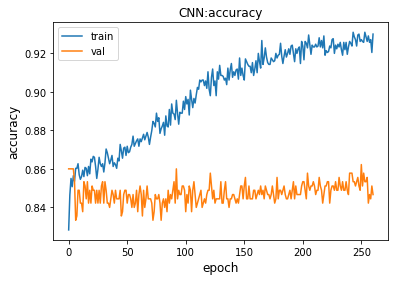

In [43]:
import matplotlib.pyplot as plt
# Plot the result
metric = "accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("CNN:" + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

Metrics report: 
              precision    recall  f1-score   support

       False       0.86      1.00      0.92       385
        True       0.00      0.00      0.00        65

    accuracy                           0.86       450
   macro avg       0.43      0.50      0.46       450
weighted avg       0.73      0.86      0.79       450



/Users/duc.letran/Desktop/FINAL PROJECT/context_transformer/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/duc.letran/Desktop/FINAL PROJECT/context_transformer/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/duc.letran/Desktop/FINAL PROJECT/context_transformer/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_divisi

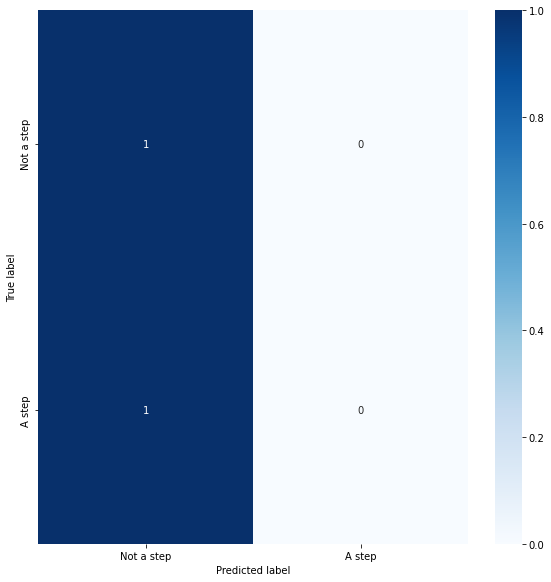

In [44]:
from sklearn.metrics import classification_report
import seaborn as sns

labels = ["Not a step", "A step"]

y_pred = model.predict(test_x_lite)
y_pred = np.argmax(y_pred, axis=1)
metrics_report = classification_report(test_y_step, y_pred)
print("Metrics report: ")
print(metrics_report)

con_mat = tf.math.confusion_matrix(labels=test_y_step, predictions=y_pred).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=4)
con_mat_df = pd.DataFrame(con_mat_norm, index=labels, columns=labels)
figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True, cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
plt.close()